In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

In [2]:
# GPU로 교체
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


In [3]:
# 이미지를 텐서로 전환
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [4]:
# 데이터 불러오기
trainset = MNIST(root="./mnist",
                 train=True,
                 transform=transform,
                 download=True)
testset = MNIST(root="./mnist",
                 train=False,
                 transform=transform,
                 download=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.06MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.40MB/s]


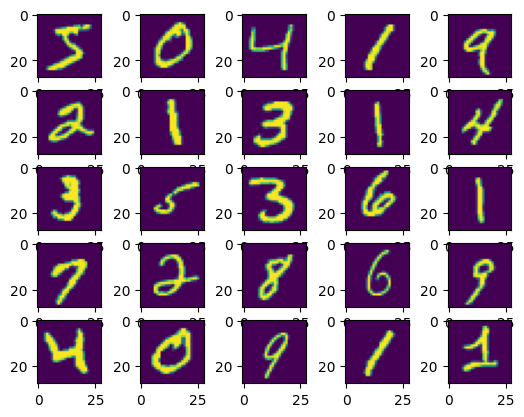

In [5]:
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

# 텐서를 이미지 객체로 전환 (ToPILImage)
to_image = ToPILImage()
fig = plt.figure()
cols = 5
rows = 5

# 시각화
for index, image_tensor in enumerate(trainset.data[:25]):
  sub_plot = fig.add_subplot(rows, cols, index + 1)
  img = to_image(image_tensor)
  sub_plot.imshow(img)

In [6]:
# 데이터로더
train_loader = DataLoader(trainset,
                          batch_size = 32,
                          shuffle = True)
test_loader = DataLoader(testset,
                         batch_size = 32,
                         shuffle = False)

In [7]:
# MLP
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(28*28, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 10)
  def forward(self, x):
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [8]:
import torch.optim as optim

mlp = MLP()
mlp.to(device)
mlp_loss = []

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr = 0.001)

num_epochs = 10

for epoch in range(num_epochs):
  mlp.train()
  running_loss = 0.0
  correct_num = 0
  for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = mlp(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  epoch_loss = running_loss / len(train_loader)
  mlp_loss.append(epoch_loss)
  print(f"Epoch {epoch+1} - Loss: {running_loss/len(train_loader):.4f}")
print("Training Complete")

Epoch 1 - Loss: 0.2362
Epoch 2 - Loss: 0.1055
Epoch 3 - Loss: 0.0757
Epoch 4 - Loss: 0.0603
Epoch 5 - Loss: 0.0505
Epoch 6 - Loss: 0.0397
Epoch 7 - Loss: 0.0367
Epoch 8 - Loss: 0.0313
Epoch 9 - Loss: 0.0278
Epoch 10 - Loss: 0.0246
Training Complete


In [9]:
correct_num = 0
total_num = 0

mlp.eval()

with torch.no_grad():
  for i, (images, labels) in enumerate(test_loader):
    images, labels = images.to(device), labels.to(device)
    outputs = mlp(images)
    _, preds = torch.max(outputs, 1)
    correct_num += (preds == labels).sum().item()
    total_num += labels.size(0)

accuracy = 100 * correct_num / total_num
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 97.58%


In [10]:
# resnet34
from torchvision.models import resnet34
resnet34 = resnet34(pretrained = True)
resnet34.conv1 = nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3, bias = False)
num_ftrs = resnet34.fc.in_features
resnet34.fc = nn.Linear(num_ftrs, 10)
resnet34 = resnet34.to(device) # 레이어 수정 후 마지막에 .to(device) 호출

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 167MB/s]


In [11]:
import torch.optim as optim

resnet34_loss = []

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet34.parameters(), lr = 0.001)

num_epochs = 10

for epoch in range(num_epochs):
  resnet34.train()
  running_loss = 0.0
  correct_num = 0
  for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = resnet34(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  epoch_loss = running_loss / len(train_loader)
  resnet34_loss.append(epoch_loss)
  print(f"Epoch {epoch+1} - Loss: {running_loss/len(train_loader):.4f}")
print("Training Complete")

Epoch 1 - Loss: 0.1939
Epoch 2 - Loss: 0.0713
Epoch 3 - Loss: 0.0676
Epoch 4 - Loss: 0.0521
Epoch 5 - Loss: 0.0388
Epoch 6 - Loss: 0.0305
Epoch 7 - Loss: 0.0241
Epoch 8 - Loss: 0.0322
Epoch 9 - Loss: 0.0186
Epoch 10 - Loss: 0.0182
Training Complete


In [12]:
correct_num = 0
total_num = 0

resnet34.eval()

with torch.no_grad():
  for i, (images, labels) in enumerate(test_loader):
    images, labels = images.to(device), labels.to(device)
    outputs = resnet34(images)
    _, preds = torch.max(outputs, 1)
    correct_num += (preds == labels).sum().item()
    total_num += labels.size(0)

accuracy = 100 * correct_num / total_num
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 99.19%


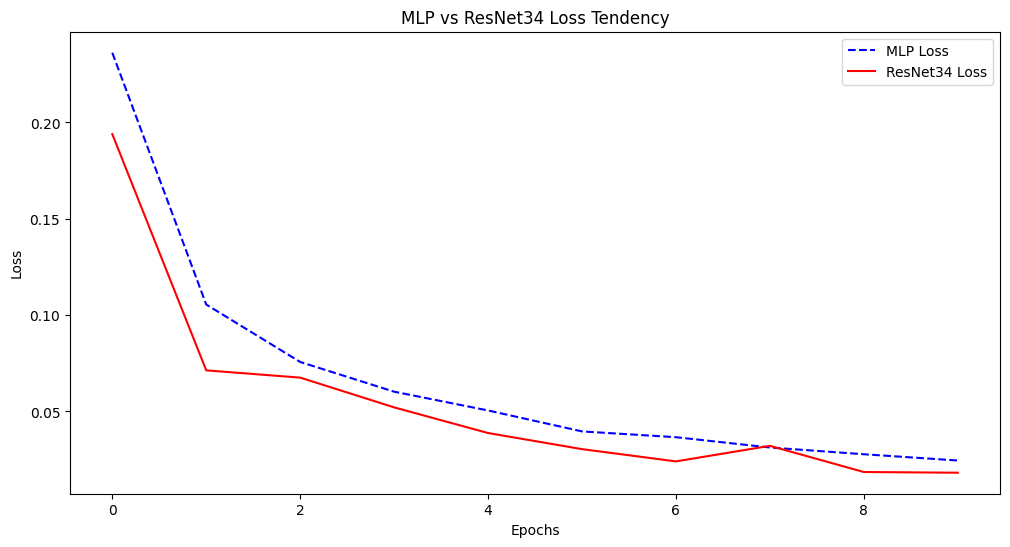

In [13]:
# loss 추이 시각화
plt.figure(figsize=(12, 6))
plt.plot(mlp_loss, label='MLP Loss', color='blue', linestyle='--')
plt.plot(resnet34_loss, label='ResNet34 Loss', color='red')
plt.title("MLP vs ResNet34 Loss Tendency")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()